In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Semantic Segmentation Pytorch 1.x <a target="_blank" href="https://colab.research.google.com/github/HarrisDePerceptron/dinov2/blob/feature-segmentation-notebook/notebooks/semantic_segmentation-pyt1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
! conda env list
! conda install -c conda-forge cudatoolkit-dev=11.7

# conda environments:
#
base                     /usr/local

Solving environment: / - \ | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.



In [3]:
! nvcc --version
! python --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
Python 3.10.10


In [4]:
! pip uninstall -y torch torchvision
! pip install torch==1.12.1 torchvision cuml-cu11 --extra-index-url https://download.pytorch.org/whl/cu116 --extra-index-url https://pypi.nvidia.com
! pip install omegaconf torchmetrics==0.10.3 fvcore iopath xformers==0.0.12 submitit

! pip install openmim
! mim uninstall -y mmcv-full
! mim install mmcv-full==1.5.3
! pip uninstall -y mmsegmentation
! mim install mmsegmentation==0.27.0


Found existing installation: torch 1.12.1+cu116
Uninstalling torch-1.12.1+cu116:
  Successfully uninstalled torch-1.12.1+cu116
Found existing installation: torchvision 0.13.1+cu116
Uninstalling torchvision-0.13.1+cu116:
  Successfully uninstalled torchvision-0.13.1+cu116
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116, https://pypi.nvidia.com
  Using cached https://download.pytorch.org/whl/cu116/torch-1.12.1%2Bcu116-cp310-cp310-linux_x86_64.whl (1904.8 MB)
  Using cached torchvision-0.17.0-cp310-cp310-manylinux1_x86_64.whl (6.9 MB)
  Using cached torchvision-0.16.2-cp310-cp310-manylinux1_x86_64.whl (6.8 MB)
  Using cached torchvision-0.16.1-cp310-cp310-manylinux1_x86_64.whl (6.8 MB)
  Using cached torchvision-0.16.0-cp310-cp310-manylinux1_x86_64.whl (6.9 MB)
  Using cached torchvision-0.15.2-cp310-cp310-manylinux1_x86_64.whl (6.0 MB)
  Using cached torchvision-0.15.1-cp310-cp310-manylinux1_x86_64.whl (6.0 MB)
  Using cached https://download.pytorch.o

In [5]:
import os
import sys

current_directory = os.getcwd()
REPO_PATH =  f"{current_directory}/dinov2"

! git clone https://github.com/facebookresearch/dinov2.git
%cd {REPO_PATH}
! git checkout 2302b6b
%cd {current_directory}
! pwd

sys.path.append(REPO_PATH)


fatal: destination path 'dinov2' already exists and is not an empty directory.
/content/dinov2
HEAD is now at 2302b6b Update vision_transformer.py (#331)
/content
/content


In [6]:
import torch
import torchvision
import mmcv
import xformers
import mmseg
print(torch.__version__)
print(torch.version.cuda)
print(mmcv.__version__)
print(xformers.__version__)
print(mmseg.__version__)

1.12.1+cu116
11.6
1.5.3
0.0.12
0.27.0


## Utilities

In [7]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F
from mmseg.apis import init_segmentor, inference_segmentor

import dinov2.eval.segmentation.models


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_segmenter(cfg, backbone_model):
    model = init_segmentor(cfg)
    model.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
    )
    if hasattr(backbone_model, "patch_size"):
        model.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))
    model.init_weights()
    return model

## Load pretrained backbone

In [27]:
BACKBONE_SIZE = "base" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate=none)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1): NestedTen

## Load pretrained segmentation head

In [30]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_SCALE_COUNT = 3 # more scales: slower but better results, in (1,2,3,4,5)
HEAD_DATASET = "voc2012" # in ("ade20k", "voc2012")
HEAD_TYPE = "ms" # in ("ms, "linear")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")
if HEAD_TYPE == "ms":
    cfg.data.test.pipeline[1]["img_ratios"] = cfg.data.test.pipeline[1]["img_ratios"][:HEAD_SCALE_COUNT]
    print("scales:", cfg.data.test.pipeline[1]["img_ratios"])

model = create_segmenter(cfg, backbone_model=backbone_model)
load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.cuda()
model.eval()

/usr/local/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
2024-02-03 20:27:46,947 - mmcv - INFO - initialize BNHead with init_cfg {'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
2024-02-03 20:27:46,956 - mmcv - INFO - 
decode_head.conv_seg.weight - torch.Size([21, 3072, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2024-02-03 20:27:46,964 - mmcv - INFO - 
decode_head.conv_seg.bias - torch.Size([21]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2024-02-03 20:27:46,966 - mmcv - INFO - 
decode_head.bn.weight - torch.Size([3072]): 
The value is the same before and after calling `init_weights` of EncoderDecoder  
 
2024-02-03 20:27:46,966 - mmcv - INFO - 
decode_head.bn.bias - torch.Size([3072]): 
The value is 

scales: [1.0, 1.32, 1.73]
load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_voc2012_ms_head.pth


EncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): BNHead(
    input_transform=resize_concat, ignore_index=255, align_corners=False
    (loss_decode): CrossEntropyLoss(avg_non_ignore=False)
    (conv_seg): Conv2d(3072, 21, kernel_size=(1, 1), stride=(1, 1))
    (bn): SyncBatchNorm(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  init_cfg={'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
)

## Load sample image

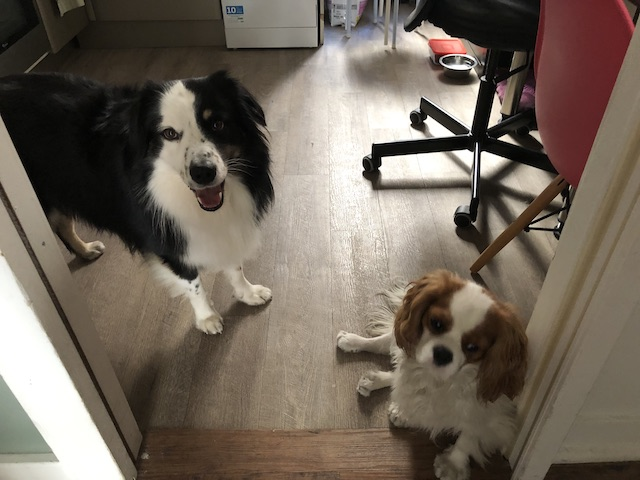

In [34]:
import urllib

from PIL import Image


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"

image = load_image_from_url(EXAMPLE_IMAGE_URL)

display(image)

## Semantic segmentation on sample image

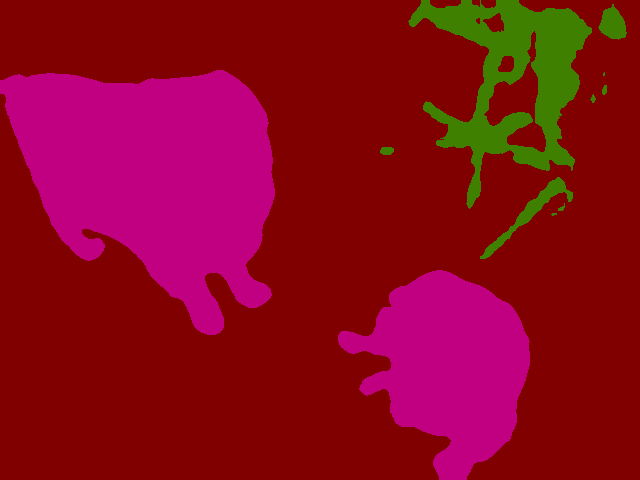

In [35]:
import numpy as np

import dinov2.eval.segmentation.utils.colormaps as colormaps


DATASET_COLORMAPS = {
    "ade20k": colormaps.ADE20K_COLORMAP,
    "voc2012": colormaps.VOC2012_COLORMAP,
}


def render_segmentation(segmentation_logits, dataset):
    colormap = DATASET_COLORMAPS[dataset]
    colormap_array = np.array(colormap, dtype=np.uint8)
    segmentation_values = colormap_array[segmentation_logits + 1]
    return Image.fromarray(segmentation_values)


array = np.array(image)[:, :, ::-1] # BGR
segmentation_logits = inference_segmentor(model, array)[0]
segmented_image = render_segmentation(segmentation_logits, HEAD_DATASET)
display(segmented_image)

In [36]:
print(segmentation_logits.shape)

(480, 640)
